<a href="https://colab.research.google.com/github/j-buss/wi-dpi-analysis/blob/development/blog/1_A_High_Level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Salary and Education in Wisconsin - 7.1 Blog - High Level

### Import Libraries

In [0]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
import seaborn as sns
import matplotlib.pyplot as plt

from google.cloud import bigquery
import matplotlib

In [0]:
%matplotlib inline
plt.style.use('bmh')

In [3]:
import matplotlib.style as style
style.available

['Solarize_Light2',
 'classic',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-poster',
 'fast',
 'seaborn-ticks',
 'seaborn-colorblind',
 'seaborn-talk',
 'tableau-colorblind10',
 'seaborn-dark',
 'fivethirtyeight',
 'seaborn-darkgrid',
 '_classic_test',
 'seaborn-paper',
 'seaborn-deep',
 'seaborn',
 'dark_background',
 'seaborn-bright',
 'seaborn-whitegrid',
 'grayscale',
 'seaborn-white',
 'bmh',
 'seaborn-dark-palette',
 'seaborn-pastel',
 'ggplot']

In [0]:
style.use('fivethirtyeight')

### Functions

In [0]:
# To help with the pie charts later
def make_autopct(values):
  def my_autopct(pct):
    total = sum(values)
    val = int(round(pct*total/100.0))
    return '{p:.2f}% \n({v:,d})'.format(p=pct,v=val)
  return my_autopct

### Processing

In [0]:
# Authenticate to GCS.
from google.colab import auth
auth.authenticate_user()

In [0]:
project_id='wi-dpi-010'
landing_dataset_name='landing'
refined_dataset_name='refined'
gold_dataset_name='gold'

In [0]:
bq_client = bigquery.Client(project=project_id)

## Analysis

There are many aids, teachers, and administrators who have many roles. The information provided by the Wisconsin Department of Public Instruction is a mix of information for an individual as well as information about the individual's role.

The state only provides salary information for individuals that have a contract with the state. 

### How many individuals have a contract with a public school?

In [0]:
sql_educator_master_data ='''
  SELECT
    *
  FROM
    {}.{}
'''.format('refined','2017_educator_master_data')

In [10]:
df_emd = pd.read_gbq(sql_educator_master_data, project_id=project_id)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value for dialect is changing to "standard" in a future version of pandas-gbq. Pass in dialect="legacy" to disable this warning.
  """Entry point for launching an IPython kernel.


In [11]:
df_emd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143493 entries, 0 to 143492
Data columns (total 18 columns):
research_id                      143493 non-null int64
first_name                       143493 non-null object
last_name                        143493 non-null object
gender                           143493 non-null object
race_ethnicity_cd                143493 non-null object
race_ethnicity_desc              143493 non-null object
birth_year                       143493 non-null int64
max_contract_high_degree_cd      73332 non-null object
max_contract_local_experience    73359 non-null float64
max_contract_total_experience    73359 non-null float64
Rec_Cnt                          143493 non-null int64
Assignment_FTE                   128948 non-null float64
Contract_Cnt                     143493 non-null int64
Salary_Cnt                       143493 non-null int64
Null_Salary_Cnt                  143493 non-null int64
Salary                           73359 non-null float64

In [0]:
df_emd_wo_salary = df_emd[df_emd['Salary_Cnt']==0]
df_emd_w_salary = df_emd[df_emd['Salary_Cnt']!=0]

In [0]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels_1 = ['Parties \nw/o Salary', 'Parties \nwith Salary']
values_1 = [df_emd_wo_salary.count().max(), df_emd_w_salary.count().max()]

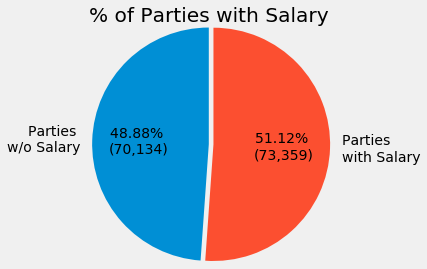

In [53]:
plt.title('% of Parties with Salary')
plt.pie(values_1, explode=(0,0.05), labels=labels_1, autopct=make_autopct(values_1),
       shadow=False, startangle=90, frame=False, radius=1.25)
plt.show
plt.savefig('01_Perc_Parties_Salary.png', bbox_inches = 'tight', pad_inches=0.25, dpi=300)

#### How many of the individuals with a Salary are Teachers vs. Administrators?

We are looking at the individuals that have a salary. They can be grouped into 3 broad categories:


1.   Teachers
2.   Administrators
3.   Other (e.g. Pupil Services, Aides / Paraprofessionals, Other)



In [30]:
df_emd_w_salary.groupby('Pos_Cat_Flag').count()[['research_id']].sort_values(by=['research_id'],ascending=False)

,research_id
Pos_Cat_Flag,
T,62656
O,6185
A,4518


In [0]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels_2 = [
    'Teachers' ,
    'Other',
    'Administrators'
]
values_2 = [
          df_emd_w_salary[(df_emd_w_salary['Pos_Cat_Flag']=='T')].count().max(), 
          df_emd_w_salary[(df_emd_w_salary['Pos_Cat_Flag']=='O')].count().max(),
          df_emd_w_salary[(df_emd_w_salary['Pos_Cat_Flag']=='A')].count().max()
         ]

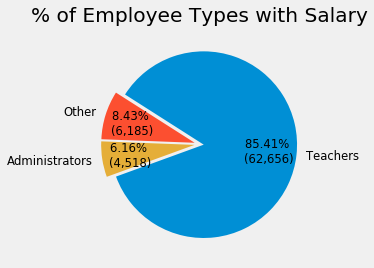

In [52]:
plt.title('% of Employee Types with Salary')
plt.pie(values_2, explode=(0.05,0.05, 0.05), labels=labels_2, autopct=make_autopct(values_2),
       shadow=False, startangle=200, frame=False, radius=1, pctdistance=0.70, textprops={'size': 'smaller'})
plt.show
plt.savefig('02_Perc_Emp_Types_Salary.png', bbox_inches = 'tight', pad_inches=0.25, dpi=300)

#### What is the distribution of Teacher Pay?

In [0]:
df_t = df_emd_w_salary[(df_emd_w_salary['Pos_Cat_Flag']=='T')]
df_a = df_emd_w_salary[(df_emd_w_salary['Pos_Cat_Flag']=='A')]

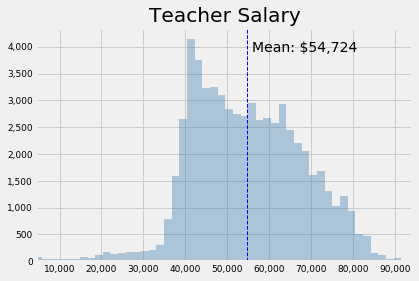

In [50]:
t_sal = df_t['Salary']
sal_graph = sns.distplot(t_sal, bins=200, hist=True, color="steelblue", kde=False, label="Teachers")

sal_graph.set_xlim(left = np.percentile(t_sal, .1), right = np.percentile(t_sal, 99.9))

sal_graph.set_title('Teacher Salary', loc='center')
sal_graph.tick_params(axis = 'both', labelsize = 9)
sal_graph.get_xaxis().set_major_formatter(
  matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
sal_graph.get_yaxis().set_major_formatter(
  matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

sal_graph.xaxis.label.set_visible(False)
sal_graph.axvline(t_sal.mean(), color='b', linestyle='dashed', linewidth=1)
_, max_ = plt.ylim()
plt.text(t_sal.mean() + t_sal.mean()/50, 
         max_ - max_/10, 
         'Mean: ${:,.0f}'.format(t_sal.mean()))
plt.savefig('03_Salary_Histogram_Teacher_Mean.png', dpi=300)

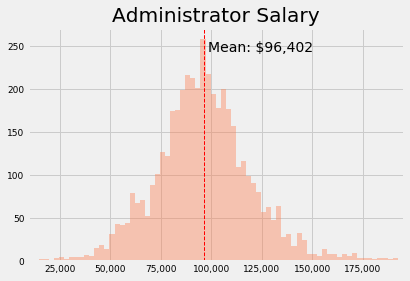

In [54]:
a_sal = df_a['Salary']
sal_graph = sns.distplot(a_sal, bins=100, hist=True, color="coral", kde=False, label="Teachers")

sal_graph.set_xlim(left = np.percentile(a_sal, .1), right = np.percentile(a_sal, 99.9))

sal_graph.set_title('Administrator Salary', loc='center')
sal_graph.tick_params(axis = 'both', labelsize = 9)
sal_graph.get_xaxis().set_major_formatter(
  matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
sal_graph.get_yaxis().set_major_formatter(
  matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

sal_graph.xaxis.label.set_visible(False)
sal_graph.axvline(a_sal.mean(), color='r', linestyle='dashed', linewidth=1)
_, max_ = plt.ylim()
plt.text(a_sal.mean() + a_sal.mean()/50, 
         max_ - max_/10, 
         'Mean: ${:,.0f}'.format(a_sal.mean()))
plt.savefig('04_Salary_Histogram_Administrator_Mean.png', dpi=300)

In [0]:
first_year = np.round(df_t[(df_t['max_contract_total_experience']<1.0) & (df_t['Assignment_FTE']>=1.0)]['Salary'].mean(),2)

In [0]:
ten_year = np.round(df_t[(df_t['max_contract_total_experience']<11.0) & (df_t['max_contract_total_experience']>9.0) & (df_t['Assignment_FTE']>=1.0)]['Salary'].mean(),2)

In [0]:
twenty_year = np.round(df_t[(df_t['max_contract_total_experience']<21.0) & (df_t['max_contract_total_experience']>19.0) & (df_t['Assignment_FTE']>=1.0)]['Salary'].mean(),2)

In [0]:
thirty_year = np.round(df_t[(df_t['max_contract_total_experience']<31.0) & (df_t['max_contract_total_experience']>29.0) & (df_t['Assignment_FTE']>=1.0)]['Salary'].mean(),2)

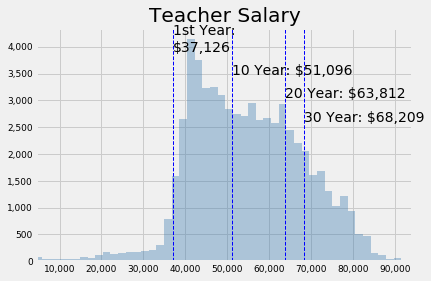

In [91]:
t_sal = df_t['Salary']
sal_graph = sns.distplot(t_sal, bins=200, hist=True, color="steelblue", kde=False, label="Teachers")

sal_graph.set_xlim(left = np.percentile(t_sal, .1), right = np.percentile(t_sal, 99.9))

sal_graph.set_title('Teacher Salary', loc='center')
sal_graph.tick_params(axis = 'both', labelsize = 9)
sal_graph.get_xaxis().set_major_formatter(
  matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
sal_graph.get_yaxis().set_major_formatter(
  matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

sal_graph.xaxis.label.set_visible(False)

sal_graph.axvline(first_year, color='b', linestyle='dashed', linewidth=1)
sal_graph.text(first_year,
               max_ - max_/10,
               '1st Year: \n${:,.0f}'.format(first_year))

sal_graph.axvline(ten_year, color='b', linestyle='dashed', linewidth=1)
sal_graph.text(ten_year,
               max_ - 2*max_/10,
               '10 Year: ${:,.0f}'.format(ten_year))

sal_graph.axvline(twenty_year, color='b', linestyle='dashed', linewidth=1)
sal_graph.text(twenty_year,
               max_ - 3*max_/10,
               '20 Year: ${:,.0f}'.format(twenty_year))

sal_graph.axvline(thirty_year, color='b', linestyle='dashed', linewidth=1)
sal_graph.text(thirty_year,
               max_ - 4*max_/10,
               '30 Year: ${:,.0f}'.format(thirty_year))

_, max_ = plt.ylim()

plt.savefig('05_Salary_Decade_Teacher_Sal.png', dpi=300)